In [1]:
%run Problem_Class.ipynb

In [2]:
s=Problem_Class_CNN_DNN(seq=216,seq_ave=30,CNN_n_epochs=200,DNN_n_epochs=50,DNN_learning_rate=1e-5,batch_size=64)

In [3]:
s.pre_processing()

C:\Users\MSI-NB\AppData\Local\Temp/ipykernel_7104/802314343.py:311: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for file in tqdm_notebook(os.listdir(data_dir)):


  0%|          | 0/67 [00:00<?, ?it/s]

In [4]:
s.run_CNN()

2022-03-22 13:59:38.349765 Epoch 1, Training loss 0.011930896562949097
2022-03-22 14:01:02.757687 Epoch 10, Training loss 0.005782186056746144
2022-03-22 14:02:37.183905 Epoch 20, Training loss 0.004464854510811197
2022-03-22 14:04:07.907684 Epoch 30, Training loss 0.003563979559295511
2022-03-22 14:05:35.029682 Epoch 40, Training loss 0.0031139117457384532
2022-03-22 14:07:04.839087 Epoch 50, Training loss 0.0028928548783076916
2022-03-22 14:08:31.929219 Epoch 60, Training loss 0.002745921530248353
2022-03-22 14:10:02.159337 Epoch 70, Training loss 0.002644528271251853
2022-03-22 14:11:33.255282 Epoch 80, Training loss 0.002560513116353374
2022-03-22 14:13:06.261111 Epoch 90, Training loss 0.002484297690427882
2022-03-22 14:14:37.834925 Epoch 100, Training loss 0.0024432352970157247
2022-03-22 14:16:11.080506 Epoch 110, Training loss 0.0024106782990087707
2022-03-22 14:17:43.839842 Epoch 120, Training loss 0.0023808827739427926
2022-03-22 14:19:11.832996 Epoch 130, Training loss 0.002

In [5]:
class Problem_DNN:
    def __init__(self,seq=216,seq_ave=10,CNN_n_epochs=200,DNN_n_epochs=100,DNN_learning_rate=1e-4,batch_size=64):
        self.seq=seq
        self.seq_ave=seq_ave
        self.CNN_n_epochs=CNN_n_epochs
        self.DNN_n_epochs=DNN_n_epochs
        self.DNN_learning_rate=DNN_learning_rate
        self.batch_size=batch_size
        self.path="Tensor_"+str(self.seq)+"_"+str(self.seq_ave)+".pt"
        self.class_list=[]
    def read_class(self,s):
        for i in s.class_list:
            self.class_list.append(i)
    def form_data(self,s):
        tx = torch.load(self.path)
        tx=tx.double()
        data,label=tx.split([tx.shape[1]-1,1],dim=1)
        data=s.CNN.mm_data.transform(data)
        data=torch.tensor(data)
        data_train_dynamic=torch.zeros(len(data),1,3,s.seq)
        for i in range(0,len(data)):
            data_train_dynamic[i]=torch.reshape(data[i][10:10+s.seq*3],(3,-1))

        model = Net()
        model.load_state_dict(torch.load('CNN2d.pt'))
        out=model(data_train_dynamic)
        out=s.CNN.mm_label.inverse_transform(out.detach().numpy())

        for i in self.class_list:
            i.pre=torch.Tensor(out[0:len(i.EPOC)-s.seq+1])
            out=out[len(i.EPOC)-s.seq+1:]

In [6]:
t=Problem_DNN(seq=216,seq_ave=30,CNN_n_epochs=200,DNN_n_epochs=50,DNN_learning_rate=1e-5,batch_size=64)

In [7]:
t.read_class(s)

In [8]:
t.form_data(s)

In [9]:
c=0
for i in t.class_list:
    i.k=[]
    i.b=[]
    E=torch.Tensor(i.EPOC[t.seq-1:])
    V=torch.Tensor(i.v[t.seq-1:])
    T=torch.Tensor(i.Time[t.seq-1:])
    P=torch.Tensor(i.pre)
    pre_run=[]
    pre_stand=[]
    E_run=[]
    E_stand=[]
    time_run=[]
    time_stand=[]
    for j in range(len(E)):
        if V[j]>0: 
            pre_run.append(P[j])
            E_run.append(E[j])
            time_run.append(T[j])
        else:
            pre_stand.append(P[j])
            E_stand.append(E[j])
            time_stand.append(T[j])
    try:
        b=-(sum(pre_run)-sum(E_run))/len(pre_run)
        i.b.append(b)
    except:
        i.b.append(0)
    try:
        b=-(sum(pre_stand)-sum(E_stand))/len(pre_stand)
        i.b.append(b)
    except:
        i.b.append(0)
    

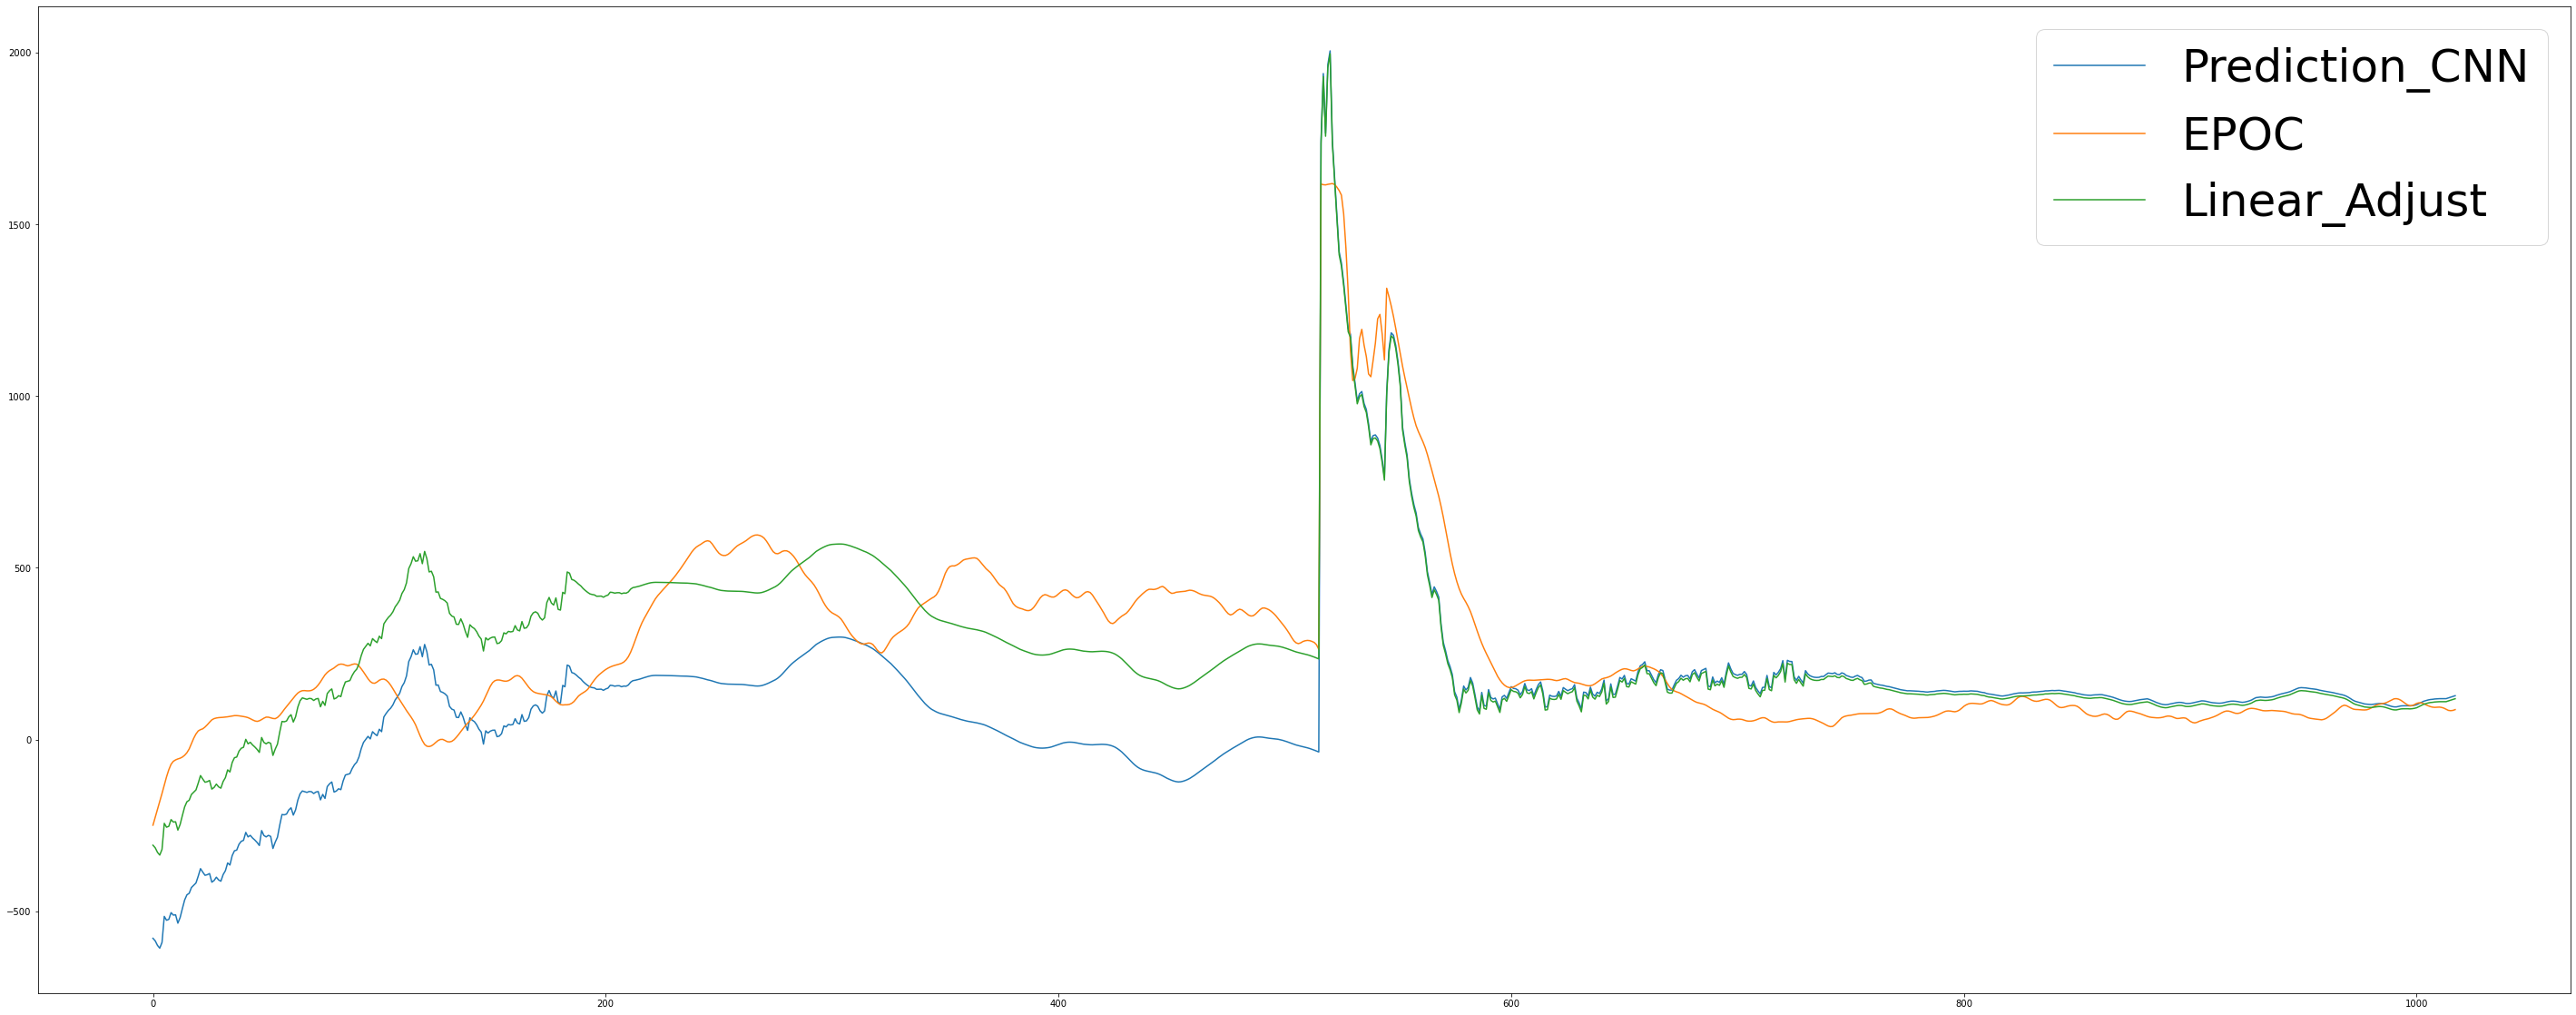

In [10]:
i=52
plt.figure(figsize=(50,20))
zz=np.zeros(len(t.class_list[i].pre))
p1,=plt.plot(t.class_list[i].pre)
p2,=plt.plot(t.class_list[i].EPOC[t.seq-1:])
for k in range(len(zz)):
    if t.class_list[i].v[t.seq-1+k]>0:
        zz[k]=t.class_list[i].pre[k]+t.class_list[i].b[0]
    else:
        zz[k]=t.class_list[i].pre[k]+t.class_list[i].b[1]
p3,=plt.plot(zz)
plt.legend([p1, p2,p3], ["Prediction_CNN", "EPOC","Linear_Adjust"], loc='upper right',fontsize=50)

In [11]:
x=np.zeros((1,12))
for i in t.class_list:
    xx=np.array([i.RMR,i.Age,i.Height,i.Weight,i.HRmax,i.HRrest,i.Gender,i.BMI,i.Temp,i.Humidity,max(i.v),i.b[0]])
    xx=xx.reshape(1,-1)
    x=np.append(x,xx,axis=0)
x=np.delete(x,0,0)   
x=x.astype(float) 
dx_b1=torch.tensor(x)

tx=dx_b1
data,label=tx.split([11,1],dim=1)
# 归一化
#train_label = mm.fit_transform(train_data)
# 反归一化
#predict_value = mm.inverse_transform(predict_value)
b1_data=MinMaxScaler()
b1_label=MinMaxScaler()
data=b1_data.fit_transform(data)
label=b1_label.fit_transform(label)

data=torch.tensor(data)
label=torch.tensor(label)

data_train,data_test=data.split([int(tx.shape[0]*0.8),tx.shape[0]-int(tx.shape[0]*0.8)],dim=0)
label_train,label_test=label.split([int(tx.shape[0]*0.8),tx.shape[0]-int(tx.shape[0]*0.8)],dim=0)

Train_Data =[]
for i in range(0,len(label_train)):
    Train_Data.append((data_train[i],label_train[i]))

batch_size=64
train_loader = torch.utils.data.DataLoader(Train_Data, batch_size=64,
                                           shuffle=True)
torch.set_default_tensor_type(torch.DoubleTensor)
model_b1 = nn.Sequential(
            nn.Linear(11, 24),
            nn.Tanh(),
            nn.Linear(24,  12),
            nn.Tanh(),
            nn.Linear(12, 1))
            

learning_rate = 1e-1

optimizer = optim.SGD(model_b1.parameters(), lr=learning_rate)

loss_fn = nn.MSELoss()

n_epochs = 500

for epoch in range(n_epochs):
    for data, label in train_loader:
        outputs = model_b1(data)
        loss = loss_fn(outputs, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

out=model_b1(data_test)
out = b1_label.inverse_transform(out.detach().numpy())
label_plot=b1_label.inverse_transform(label_test)

C:\Users\MSI-NB\AppData\Local\Temp/ipykernel_7104/2640453151.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xx=np.array([i.RMR,i.Age,i.Height,i.Weight,i.HRmax,i.HRrest,i.Gender,i.BMI,i.Temp,i.Humidity,max(i.v),i.b[0]])


Epoch: 0, Loss: 0.353380
Epoch: 1, Loss: 0.095027
Epoch: 2, Loss: 0.043721
Epoch: 3, Loss: 0.034180
Epoch: 4, Loss: 0.032454
Epoch: 5, Loss: 0.032007
Epoch: 6, Loss: 0.031763
Epoch: 7, Loss: 0.031560
Epoch: 8, Loss: 0.031374
Epoch: 9, Loss: 0.031199
Epoch: 10, Loss: 0.031034
Epoch: 11, Loss: 0.030879
Epoch: 12, Loss: 0.030733
Epoch: 13, Loss: 0.030596
Epoch: 14, Loss: 0.030465
Epoch: 15, Loss: 0.030342
Epoch: 16, Loss: 0.030226
Epoch: 17, Loss: 0.030115
Epoch: 18, Loss: 0.030010
Epoch: 19, Loss: 0.029910
Epoch: 20, Loss: 0.029816
Epoch: 21, Loss: 0.029725
Epoch: 22, Loss: 0.029639
Epoch: 23, Loss: 0.029557
Epoch: 24, Loss: 0.029479
Epoch: 25, Loss: 0.029404
Epoch: 26, Loss: 0.029333
Epoch: 27, Loss: 0.029264
Epoch: 28, Loss: 0.029199
Epoch: 29, Loss: 0.029136
Epoch: 30, Loss: 0.029075
Epoch: 31, Loss: 0.029017
Epoch: 32, Loss: 0.028961
Epoch: 33, Loss: 0.028907
Epoch: 34, Loss: 0.028855
Epoch: 35, Loss: 0.028805
Epoch: 36, Loss: 0.028757
Epoch: 37, Loss: 0.028710
Epoch: 38, Loss: 0.028

In [12]:
x=np.zeros((1,12))
for i in t.class_list:
    xx=np.array([i.RMR,i.Age,i.Height,i.Weight,i.HRmax,i.HRrest,i.Gender,i.BMI,i.Temp,i.Humidity,max(i.v),i.b[1]])
    xx=xx.reshape(1,-1)
    x=np.append(x,xx,axis=0)
x=np.delete(x,0,0)   
x=x.astype(float) 
dx_b2=torch.tensor(x)

tx=dx_b2
data,label=tx.split([11,1],dim=1)
# 归一化
#train_label = mm.fit_transform(train_data)
# 反归一化
#predict_value = mm.inverse_transform(predict_value)
b2_data=MinMaxScaler()
b2_label=MinMaxScaler()
data=b2_data.fit_transform(data)
label=b2_label.fit_transform(label)

data=torch.tensor(data)
label=torch.tensor(label)

data_train,data_test=data.split([int(tx.shape[0]*0.8),tx.shape[0]-int(tx.shape[0]*0.8)],dim=0)
label_train,label_test=label.split([int(tx.shape[0]*0.8),tx.shape[0]-int(tx.shape[0]*0.8)],dim=0)

Train_Data =[]
for i in range(0,len(label_train)):
    Train_Data.append((data_train[i],label_train[i]))

batch_size=64
train_loader = torch.utils.data.DataLoader(Train_Data, batch_size=64,
                                           shuffle=True)
torch.set_default_tensor_type(torch.DoubleTensor)
model_b2 = nn.Sequential(
            nn.Linear(11, 24),
            nn.Tanh(),
            nn.Linear(24,  12),
            nn.Tanh(),
            nn.Linear(12, 1))
            

learning_rate = 1e-1

optimizer = optim.SGD(model_b2.parameters(), lr=learning_rate)

loss_fn = nn.MSELoss()

n_epochs = 500

for epoch in range(n_epochs):
    for data, label in train_loader:
        outputs = model_b2(data)
        loss = loss_fn(outputs, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

out=model_b2(data_test)
out = b2_label.inverse_transform(out.detach().numpy())
label_plot=b2_label.inverse_transform(label_test)

C:\Users\MSI-NB\AppData\Local\Temp/ipykernel_7104/2380527222.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xx=np.array([i.RMR,i.Age,i.Height,i.Weight,i.HRmax,i.HRrest,i.Gender,i.BMI,i.Temp,i.Humidity,max(i.v),i.b[1]])


Epoch: 0, Loss: 0.501062
Epoch: 1, Loss: 0.120236
Epoch: 2, Loss: 0.043439
Epoch: 3, Loss: 0.028102
Epoch: 4, Loss: 0.025187
Epoch: 5, Loss: 0.024434
Epoch: 6, Loss: 0.024032
Epoch: 7, Loss: 0.023693
Epoch: 8, Loss: 0.023375
Epoch: 9, Loss: 0.023070
Epoch: 10, Loss: 0.022777
Epoch: 11, Loss: 0.022495
Epoch: 12, Loss: 0.022223
Epoch: 13, Loss: 0.021961
Epoch: 14, Loss: 0.021709
Epoch: 15, Loss: 0.021466
Epoch: 16, Loss: 0.021232
Epoch: 17, Loss: 0.021006
Epoch: 18, Loss: 0.020788
Epoch: 19, Loss: 0.020578
Epoch: 20, Loss: 0.020375
Epoch: 21, Loss: 0.020178
Epoch: 22, Loss: 0.019989
Epoch: 23, Loss: 0.019806
Epoch: 24, Loss: 0.019629
Epoch: 25, Loss: 0.019457
Epoch: 26, Loss: 0.019292
Epoch: 27, Loss: 0.019132
Epoch: 28, Loss: 0.018977
Epoch: 29, Loss: 0.018827
Epoch: 30, Loss: 0.018681
Epoch: 31, Loss: 0.018541
Epoch: 32, Loss: 0.018405
Epoch: 33, Loss: 0.018273
Epoch: 34, Loss: 0.018145
Epoch: 35, Loss: 0.018021
Epoch: 36, Loss: 0.017901
Epoch: 37, Loss: 0.017784
Epoch: 38, Loss: 0.017

In [19]:
c=0
alpha=0
beta=1
# for alpha in np.linspace(0,1,20):
#     for beta in np.linspace(0,1,20):
c=0
l=[i for i in range(53,63)]
l.append(64)
for i in l:
    zz=np.zeros(len(t.class_list[i].pre))
    x=np.array([ t.class_list[i].RMR,
                     t.class_list[i].Age,
                     t.class_list[i].Height,
                     t.class_list[i].Weight,
                     t.class_list[i].HRmax,
                     t.class_list[i].HRrest,
                     t.class_list[i].Gender,
                     t.class_list[i].BMI,
                     t.class_list[i].Temp,
                     t.class_list[i].Humidity,
                     max(t.class_list[i].v)])
    x=x.reshape(1, -1) 
    x=x.astype(float) 
    x=torch.tensor(x)

    k_1=1
    k_2=1
    b_1=model_b1(torch.tensor(b1_data.transform(x)))
    b_1=b1_label.inverse_transform(b_1.detach().numpy())
    b_2=model_b2(torch.tensor(b2_data.transform(x)))
    b_2=b2_label.inverse_transform(b_2.detach().numpy())
    for k in range(len(zz)):
        if t.class_list[i].v[t.seq-1+k]>0:
            zz[k]=t.class_list[i].pre[k]*alpha+t.class_list[i].pre[k]*(1-alpha)*k_1+b_1*beta
        else:
            zz[k]=t.class_list[i].pre[k]*alpha+t.class_list[i].pre[k]*(1-alpha)*k_2+b_2*beta            
    x=np.zeros(len(s.class_list[i].EPOC[t.seq-1:]))
    y=np.zeros(len(s.class_list[i].EPOC[t.seq-1:]))
    z=np.zeros(len(s.class_list[i].EPOC[t.seq-1:]))
    for j in range(len(x)):
        y[j]=0.2*t.class_list[i].v[j+t.seq-1]*1000/60*t.class_list[i].Weight+3.5*t.class_list[i].Weight
        x[j]=(t.class_list[i].EPOC[j+t.seq-1]+y[j])*t.class_list[i].Time[j+t.seq-1]
        z[j]=(zz[j]+y[j])*t.class_list[i].Time[j+t.seq-1]
    print(abs(sum(x)-sum(z))/sum(x))
    c+=abs(sum(x)-sum(z))/sum(x)
print('average accuracy:',1-c/11)
#         print(alpha)
#         print(beta)

0.25812928935119206
0.061065711445775876
0.022386697795213555
0.14157598794616538
0.06504678161652376
0.06405320759370675
0.09030904837808654
0.12053931773586654
0.27566203271199824
0.14871180666067357
0.2995988736884946
average accuracy: 0.8593564768251185
